**More information about the relationship of the data, you can go and check this link** => https://github.com/wanorn-data-scientist/ubiquant-market-prediction/blob/0f0fa2a3e15ce8471d1f07a1795af25b777845ad/ump-eda-target-analysis.ipynb

### Reference
Special thanks @Lonnie Ubiquant Market Prediction with DNN
https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn## 

## import

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

## Configuration

**Set is_training = True.**

In [2]:
class Config:
    is_training = True
    tf_record_dataset_path = "../input/ump-combinatorialpurgedgroupkfold-tf-record/"
    output_dataset_path = "../input/ubiquant-market-prediction-with-dnn-output/"
config = Config()

## Create an IntegerLookup layer for investment_id input

In [3]:
%%time
investment_ids = pd.read_csv("../input/ump-combinatorialpurgedgroupkfold-tf-record/investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

2022-03-16 10:01:24.973801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 10:01:25.122013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 10:01:25.123108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 10:01:25.126261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

CPU times: user 731 ms, sys: 612 ms, total: 1.34 s
Wall time: 3 s


## Make Tensorflow dataset

In [4]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["investment_id"], item["features"]), item["target"]
def make_dataset(file_paths, batch_size=1024, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

## Modeling

In [5]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(7e-4), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Let's take a look at this Model's architecture.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

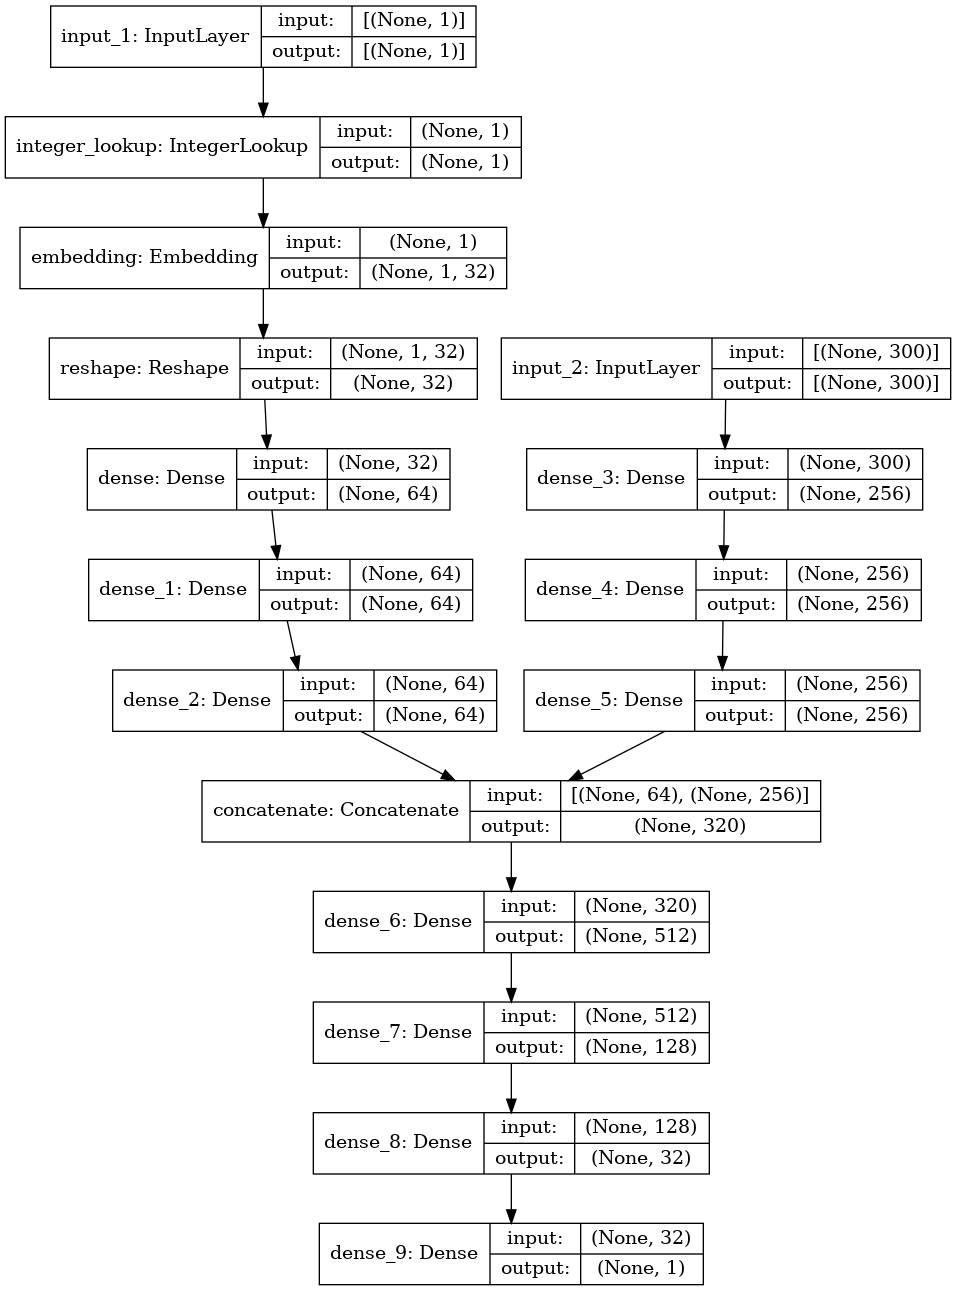

In [6]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

**Training starts here.**

Epoch 1/30
2508/2508 [==============================] - 273s 108ms/step - loss: 0.9360 - mse: 0.8270 - mae: 0.6216 - mape: 120520.7734 - rmse: 0.9094 - correlation: 0.8709 - val_loss: 0.8661 - val_mse: 0.8649 - val_mae: 0.6438 - val_mape: 125955.3203 - val_rmse: 0.9300 - val_correlation: 0.9247
Epoch 2/30
2508/2508 [==============================] - 22s 9ms/step - loss: 0.8259 - mse: 0.8224 - mae: 0.6200 - mape: 149364.8125 - rmse: 0.9069 - correlation: 0.8533 - val_loss: 0.8678 - val_mse: 0.8665 - val_mae: 0.6442 - val_mape: 131320.6406 - val_rmse: 0.9309 - val_correlation: 0.9217
Epoch 3/30
2508/2508 [==============================] - 23s 9ms/step - loss: 0.8244 - mse: 0.8194 - mae: 0.6188 - mape: 156544.7031 - rmse: 0.9052 - correlation: 0.8425 - val_loss: 0.8704 - val_mse: 0.8660 - val_mae: 0.6428 - val_mape: 139402.3750 - val_rmse: 0.9306 - val_correlation: 0.9165
Epoch 4/30
2508/2508 [==============================] - 23s 9ms/step - loss: 0.8224 - mse: 0.8169 - mae: 0.6178 - mape

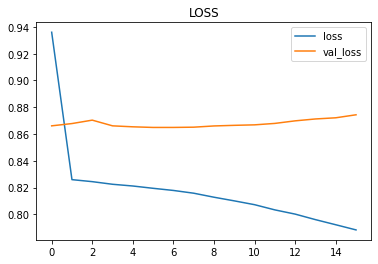

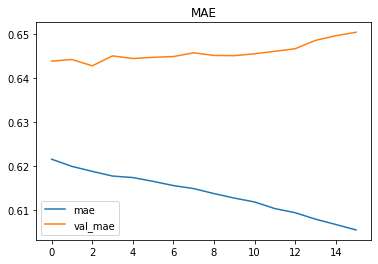

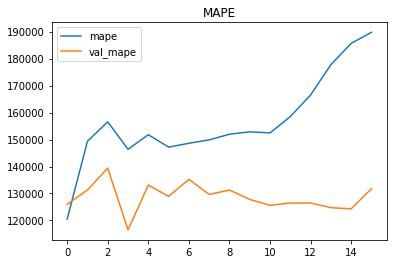

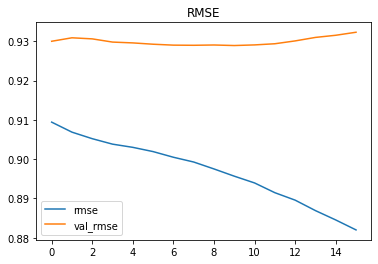

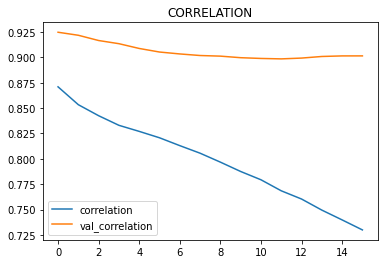

Pearson Score: 0.10129551347992889
Epoch 1/30
2548/2548 [==============================] - 299s 117ms/step - loss: 0.9490 - mse: 0.8407 - mae: 0.6197 - mape: 135431.7969 - rmse: 0.9169 - correlation: 0.8793 - val_loss: 0.8057 - val_mse: 0.8047 - val_mae: 0.6632 - val_mape: 95869.5625 - val_rmse: 0.8970 - val_correlation: 0.8934
Epoch 2/30
2548/2548 [==============================] - 25s 10ms/step - loss: 0.8387 - mse: 0.8360 - mae: 0.6182 - mape: 155202.3438 - rmse: 0.9143 - correlation: 0.8593 - val_loss: 0.8040 - val_mse: 0.8030 - val_mae: 0.6616 - val_mape: 112979.2891 - val_rmse: 0.8961 - val_correlation: 0.8849
Epoch 3/30
2548/2548 [==============================] - 22s 9ms/step - loss: 0.8378 - mse: 0.8336 - mae: 0.6171 - mape: 156230.1250 - rmse: 0.9130 - correlation: 0.8494 - val_loss: 0.8036 - val_mse: 0.8024 - val_mae: 0.6612 - val_mape: 111414.2656 - val_rmse: 0.8958 - val_correlation: 0.8811
Epoch 4/30
2548/2548 [==============================] - 25s 10ms/step - loss: 0.835

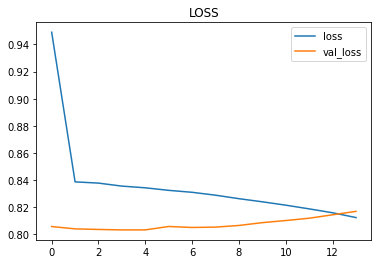

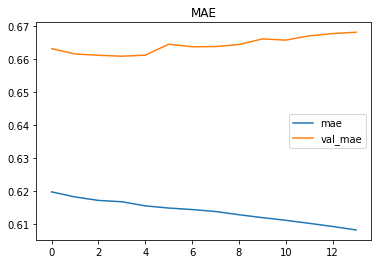

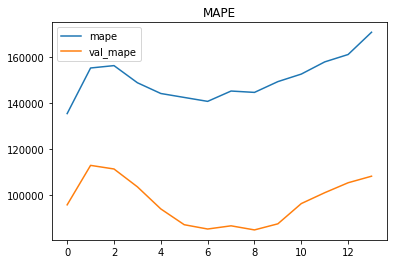

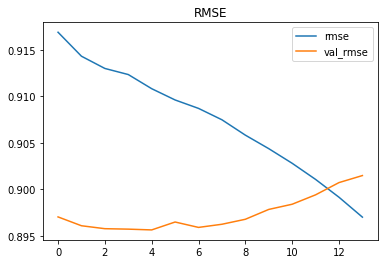

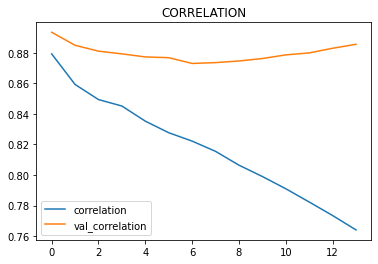

Pearson Score: 0.1250636644239904
Epoch 1/30
2442/2442 [==============================] - 339s 138ms/step - loss: 0.9445 - mse: 0.8314 - mae: 0.6259 - mape: 101034.2344 - rmse: 0.9118 - correlation: 0.8769 - val_loss: 0.8487 - val_mse: 0.8466 - val_mae: 0.6275 - val_mape: 145815.7500 - val_rmse: 0.9201 - val_correlation: 0.9026
Epoch 2/30
2442/2442 [==============================] - 28s 11ms/step - loss: 0.8299 - mse: 0.8268 - mae: 0.6243 - mape: 129475.1328 - rmse: 0.9093 - correlation: 0.8574 - val_loss: 0.8466 - val_mse: 0.8448 - val_mae: 0.6266 - val_mape: 187480.0000 - val_rmse: 0.9191 - val_correlation: 0.8917
Epoch 3/30
2442/2442 [==============================] - 21s 8ms/step - loss: 0.8281 - mse: 0.8249 - mae: 0.6237 - mape: 141377.8125 - rmse: 0.9082 - correlation: 0.8510 - val_loss: 0.8459 - val_mse: 0.8448 - val_mae: 0.6275 - val_mape: 188059.7188 - val_rmse: 0.9191 - val_correlation: 0.8908
Epoch 4/30
2442/2442 [==============================] - 21s 9ms/step - loss: 0.8265

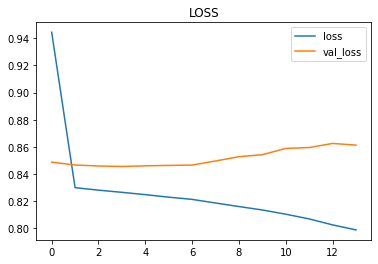

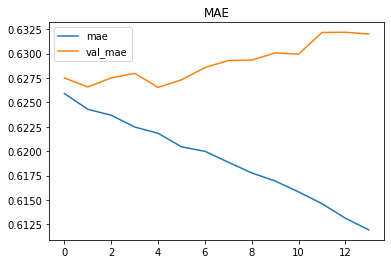

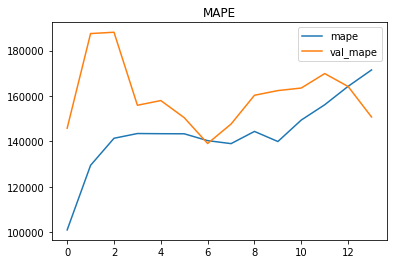

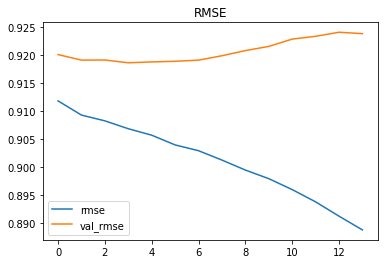

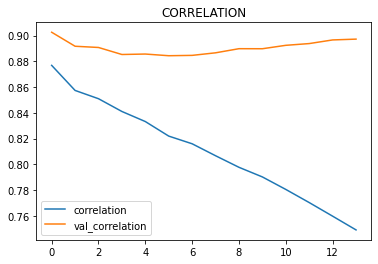

Pearson Score: 0.11501781479153075
Epoch 1/30
2335/2335 [==============================] - 330s 141ms/step - loss: 0.9417 - mse: 0.8232 - mae: 0.6255 - mape: 90786.6094 - rmse: 0.9073 - correlation: 0.8660 - val_loss: 0.8663 - val_mse: 0.8644 - val_mae: 0.6253 - val_mape: 245071.4062 - val_rmse: 0.9297 - val_correlation: 0.9171
Epoch 2/30
2335/2335 [==============================] - 29s 12ms/step - loss: 0.8221 - mse: 0.8186 - mae: 0.6238 - mape: 105359.7891 - rmse: 0.9048 - correlation: 0.8481 - val_loss: 0.8658 - val_mse: 0.8642 - val_mae: 0.6253 - val_mape: 326731.1562 - val_rmse: 0.9296 - val_correlation: 0.9123
Epoch 3/30
2335/2335 [==============================] - 20s 9ms/step - loss: 0.8199 - mse: 0.8156 - mae: 0.6226 - mape: 111014.0078 - rmse: 0.9031 - correlation: 0.8373 - val_loss: 0.8674 - val_mse: 0.8650 - val_mae: 0.6267 - val_mape: 315016.6875 - val_rmse: 0.9300 - val_correlation: 0.9121
Epoch 4/30
2335/2335 [==============================] - 20s 9ms/step - loss: 0.8189

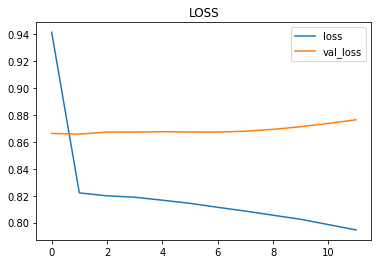

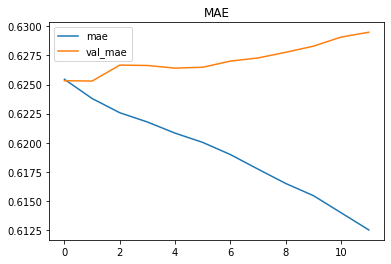

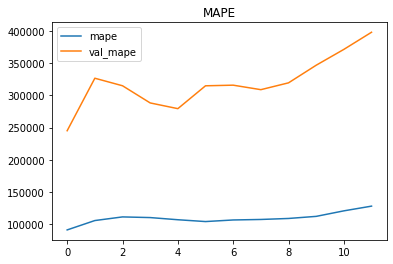

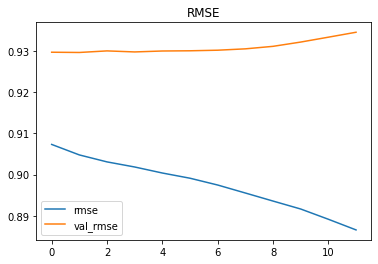

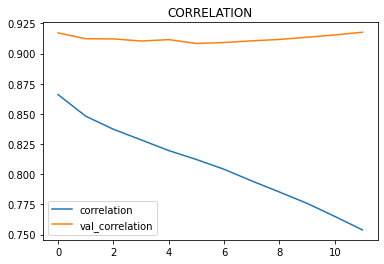

Pearson Score: 0.0939211941363836
Epoch 1/30
2306/2306 [==============================] - 313s 135ms/step - loss: 0.9608 - mse: 0.8402 - mae: 0.6327 - mape: 138717.4375 - rmse: 0.9166 - correlation: 0.8748 - val_loss: 0.8155 - val_mse: 0.8127 - val_mae: 0.5990 - val_mape: 104310.2031 - val_rmse: 0.9015 - val_correlation: 0.8817
Epoch 2/30
2306/2306 [==============================] - 22s 10ms/step - loss: 0.8393 - mse: 0.8363 - mae: 0.6314 - mape: 158563.8594 - rmse: 0.9145 - correlation: 0.8573 - val_loss: 0.8122 - val_mse: 0.8096 - val_mae: 0.6012 - val_mape: 75019.0234 - val_rmse: 0.8998 - val_correlation: 0.8762
Epoch 3/30
2306/2306 [==============================] - 21s 9ms/step - loss: 0.8373 - mse: 0.8341 - mae: 0.6305 - mape: 161044.5156 - rmse: 0.9133 - correlation: 0.8493 - val_loss: 0.8132 - val_mse: 0.8113 - val_mae: 0.5996 - val_mape: 85436.0625 - val_rmse: 0.9007 - val_correlation: 0.8795
Epoch 4/30
2306/2306 [==============================] - 20s 8ms/step - loss: 0.8360 -

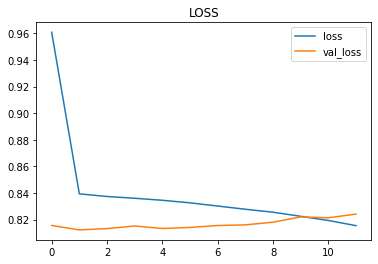

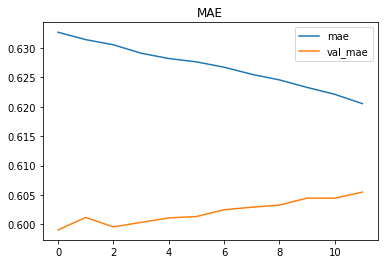

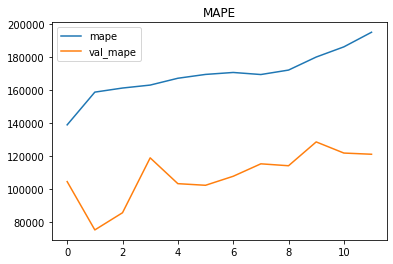

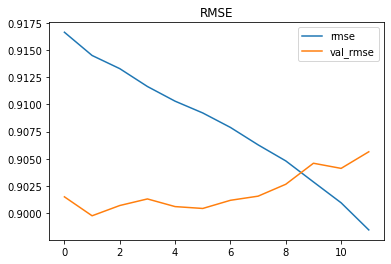

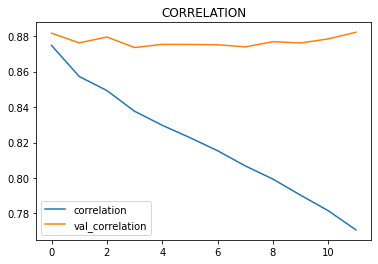

Pearson Score: 0.12657765827769268
CPU times: user 50min 46s, sys: 13min 39s, total: 1h 4min 26s
Wall time: 57min 12s


In [7]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        checkpoint = keras.callbacks.ModelCheckpoint(f"model_{i}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
        model.load_weights(f"model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")

## Submission

In [8]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
